# **Visualization of Latent Embeddings with Fashion-MNIST Class Labels**
 **Purpose of the Visualization:**

This visualization presents the latent embeddings extracted from an Autoencoder trained on the Fashion-MNIST dataset. The embeddings are processed using different dimensionality reduction techniques (like t-SNE or UMAP) and clustering algorithms (such as K-Means, DBSCAN, and HDBSCAN) to explore how the Autoencoder has captured the underlying data patterns.



In [1]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Data Manipulation and Visualization
import numpy as np
import matplotlib.pyplot as plt

# Dimensionality Reduction & Clustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


# **Loaded the Data sets of DIfferent wearables from tensorflow datasets**

In [2]:
# Load the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Print dataset shapes
print(f"Training data shape: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Labels: {y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28), Labels: (60000,)
Test data shape: (10000, 28, 28), Labels: (10000,)


# **Visualize 10 Random data from the dataset**

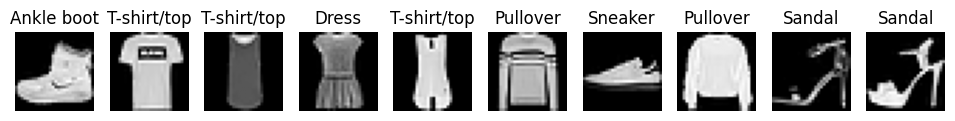

In [3]:
import matplotlib.pyplot as plt

# Class names for reference
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Function to plot sample images
def plot_sample_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

# Visualize 10 sample images
plot_sample_images(x_train, y_train, class_names)

# **Flatten our Data to process in the Auto-encoders**

In [4]:
## Checks if what normalization is needed
print(f"Min pixel value: {x_train.min()}")
print(f"Max pixel value: {x_train.max()}")

Min pixel value: 0
Max pixel value: 255


Since 255 is the max pixel for the training data, to get the normalization it should be divided by **255.0**

In [6]:
# 📌 Normalize data (0-1) and reshape to (28,28,1)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # Shape: (10000, 28, 28, 1)

# # Check shapes after preprocessing
# print(f"Training data shape after flattening: {x_train_flat.shape}")
# print(f"Test data shape after flattening: {x_test_flat.shape}")

# **Get Flattened data ready top be given to Convolutional Autoencoder**


*   **input_dim** - flattened pixels into 1d (28x28 = 784)
*   **endocing_dim** - this controls the compression value in the latent space. Value  of this tells how general or spot on an autoencoder can be in the output (lower value means more general | higher means more accurate and spot on)



In [7]:
# Import TensorFlow/Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 📌 Input layer
input_img = Input(shape=(28, 28, 1))


# **Setting up Convolutional Autoencoder**


*   **Dense** - Layers in Nueral network
 *   **128 ** - Number of nuerals where flattened data will go through
 * **Activation** - Layers where handles how data in nueral will be processed
  ** **Relu** - only takes positive data, then disregards negative data(Takes important features only)
  ** **sigmoid** - ensures data in output is balanced


*  Adam optimizer - A smart optimizer that automatically adjusts the learning rate during training.
* Binary Crossentropy - It calculates how well the model is doing by treating each pixel as a probability (since we normalized the data).





In [8]:
# imports
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape

# **Encoder (Feature Extraction)**
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Added depth
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)
latent = Dense(256, activation='relu')(x)  # Bigger latent space

# **Decoder (Reconstruction)**
x = Dense(7*7*128, activation='relu')(latent)  # Expand back
x = Reshape((7, 7, 128))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# **Define Autoencoder**
autoencoder = Model(input_img, decoded)

# **Define Encoder (for extracting embeddings)**
encoder = Model(input_img, latent)

# **Compile Autoencoder**
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# **Model Summary**
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6272)                │       1,611,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,469,249 (9.42 MB)

 Trainable params: 2,469,249 (9.42 MB)

 Non-trainable params: 0 (0.00 B)

# **Training The Convolutional Autoencoderr**

*   **input** - What the Autoencoder analyzes
*   **input** - What the Autoencoder tries to reproduce.
*   **epoch** - How many the model will re iterate or re analyze the whole dataset
*   **batch_size** - how many samples the model processes at once
*   **shuffle** - it shuffles the training data before each epoch to improve learning.
* **validation_data** - it Used as the test set to monitor validation loss and check if the model is overfitting.



In [9]:
# Train the Autoencoder
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 573s 1s/step - loss: 0.0711 - val_loss: 0.0085
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 645s 1s/step - loss: 0.0084 - val_loss: 0.0084
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 566s 1s/step - loss: 0.0084 - val_loss: 0.0084
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - loss: 0.0084 - val_loss: 0.0084
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 602s 1s/step - loss: 0.0084 - val_loss: 0.0083
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 567s 1s/step - loss: 0.0081 - val_loss: 0.0080
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - loss: 0.0080 - val_loss: 0.0080
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - loss: 0.0080 - val_loss: 0.0080
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - loss: 0.0079 - val_loss: 0.0079
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 616s 1s/step - loss: 0.0079 - val_loss: 0.0080


# **Understanding the Training output**
* **loss** - The training loss.(The less the better)
* **val_loss** - The validation loss (using unseen data from the test set).

# **Visualizing the Difference of the input data and output data**
**Things to consider**

*   If the input data is still recongnizable to the output data

If reconstructions are too blurry,we need to:
*  Increase the latent space size (e.g., from 64 to 128).
* Use more complex models like Convolutional Autoencoders (which we can try later!).




313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step


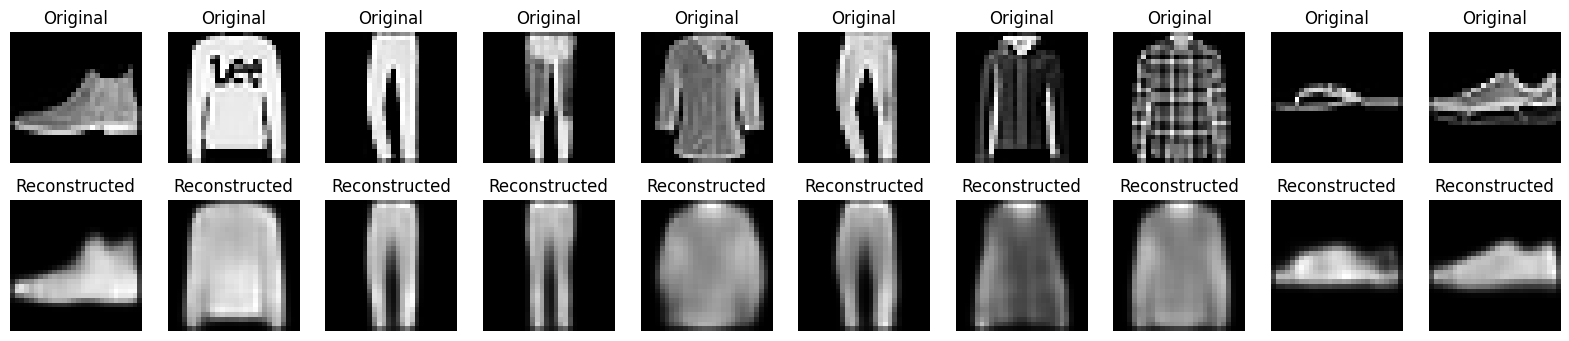

In [10]:
# Function to plot original vs reconstructed images
def plot_reconstructed_images(original, reconstructed, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')  # Remove extra dimension
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')  # Remove extra dimension
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

# Use the trained Autoencoder to reconstruct images
reconstructed_imgs = autoencoder.predict(x_test)

# Plot original vs reconstructed images
plot_reconstructed_images(x_test, reconstructed_imgs)

# **Using t-NSE dimension reduction to visualize embedings**
t-SNE reduces the 64D embeddings to 2D
* **perplexity** - balances focus between local and global clusters.
* **learning_rate** - controls how fast t-SNE adjusts during optimization.

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Latent embeddings shape: (10000, 256)
t-SNE reduced shape: (10000, 2)


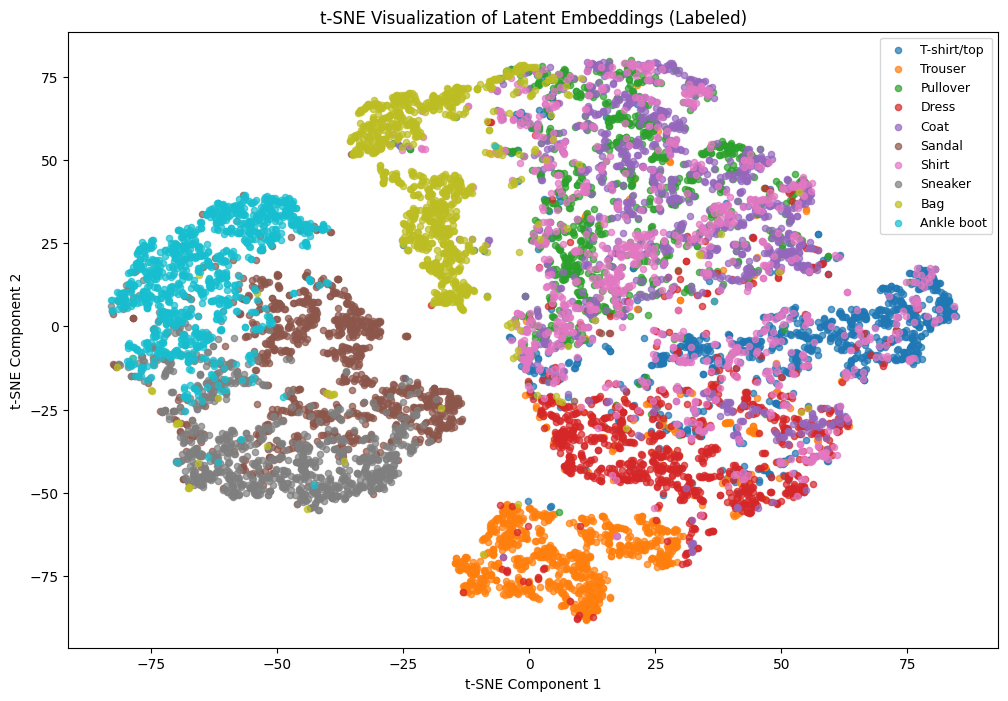

In [11]:
# Use the encoder to extract latent embeddings from the test set
latent_embeddings = encoder.predict(x_test)
latent_embeddings = latent_embeddings.reshape(latent_embeddings.shape[0], -1)  # Flatten for clustering


# Check the shape of the embeddings
print(f"Latent embeddings shape: {latent_embeddings.shape}")

# Import t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce 64D embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(latent_embeddings)

# Check the shape after t-SNE
print(f"t-SNE reduced shape: {X_tsne.shape}")

# Load test labels
(_, y_test) = fashion_mnist.load_data()[1]

# Map numerical labels to class names
mapped_labels = [class_names[label] for label in y_test]

# Plot t-SNE with actual class names
plt.figure(figsize=(12, 8))

# Create a scatter plot for each class
for i, class_name in enumerate(class_names):
    idx = np.where(y_test == i)
    plt.scatter(
        X_tsne[idx, 0],
        X_tsne[idx, 1],
        label=class_name,
        alpha=0.7,
        s=20
    )

plt.legend(loc="best", fontsize=9)
plt.title("t-SNE Visualization of Latent Embeddings (Labeled)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


# **Using PCA to reduce dimension(2d) of embeddings then K-means algo to visualize**

**Reducing Dimension using PCA**

Reduces 64D latent embeddings to 2D using PCA for visualization.

PCA reduced shape: (10000, 2)


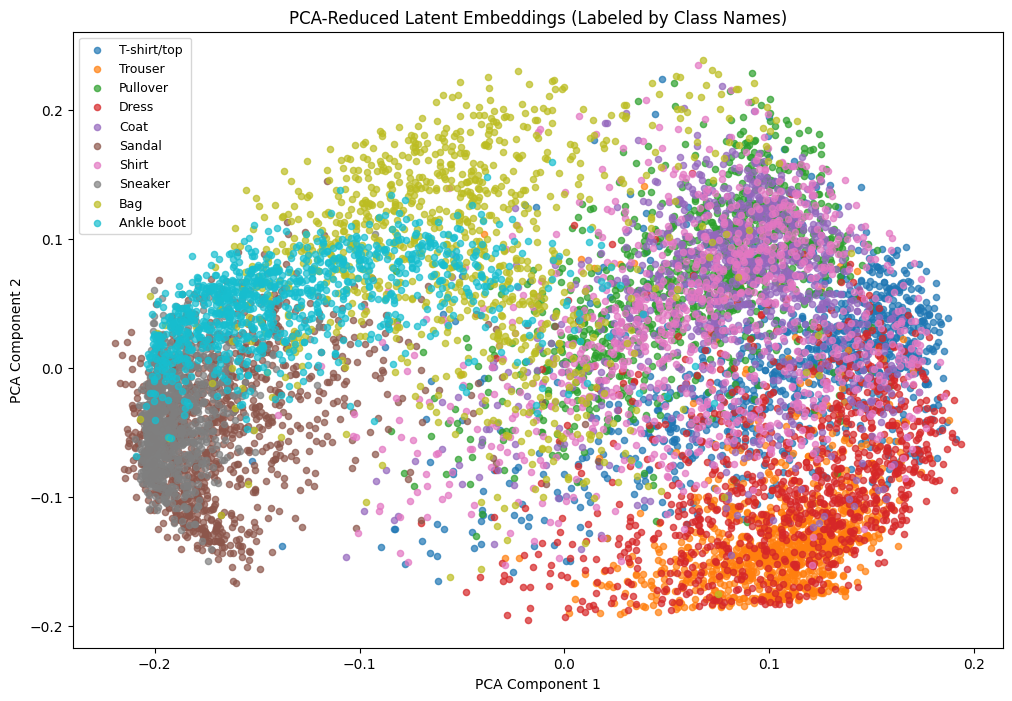

In [12]:
# Apply PCA to reduce from 64D to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(latent_embeddings)

# Check the shape after PCA
print(f"PCA reduced shape: {X_pca.shape}")
# Map true labels to class names
mapped_labels = [class_names[label] for label in y_test]

# Plot PCA-reduced data with class names
plt.figure(figsize=(12, 8))

# Create a scatter plot for each class
for i, class_name in enumerate(class_names):
    idx = np.where(y_test == i)
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        label=class_name,
        alpha=0.7,
        s=20
    )

plt.legend(loc="best", fontsize=9)
plt.title("PCA-Reduced Latent Embeddings (Labeled by Class Names)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

**Used K-means Cluster Algorigthm to help us visualize**

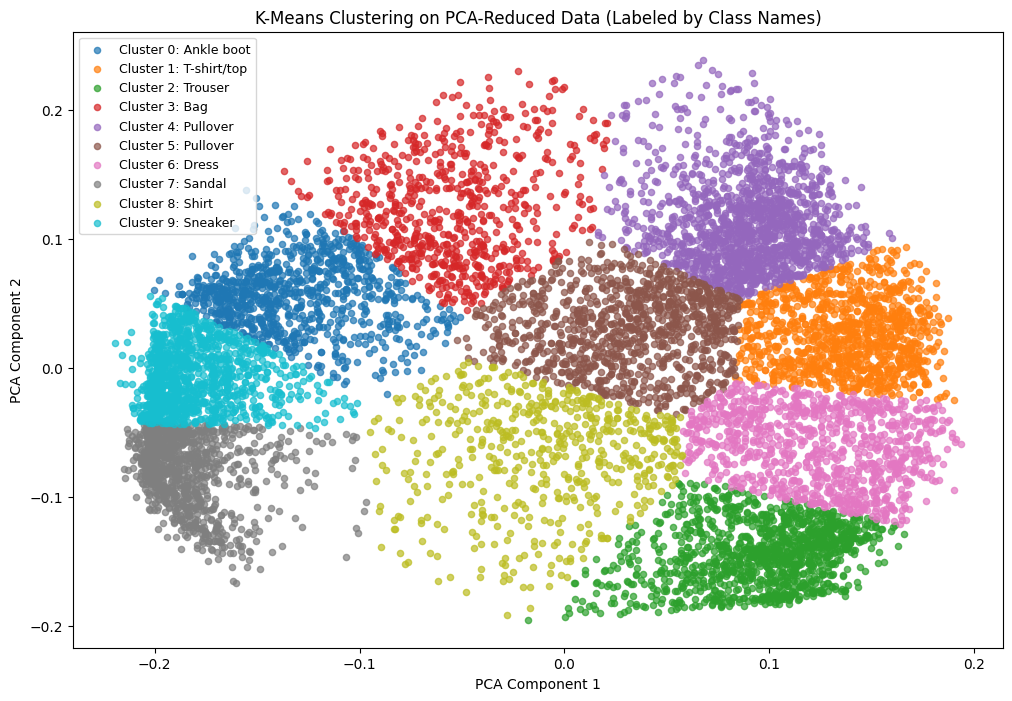

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Map K-Means clusters to the most common class in each cluster
cluster_labels = {}
for i in range(10):
    cluster_indices = np.where(kmeans_labels == i)
    common_class = Counter(y_test[cluster_indices]).most_common(1)[0][0]
    cluster_labels[i] = class_names[common_class]

# Plot K-Means clusters with mapped labels
plt.figure(figsize=(12, 8))
for i in range(10):
    idx = np.where(kmeans_labels == i)
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        label=f"Cluster {i}: {cluster_labels[i]}",
        alpha=0.7,
        s=20
    )

plt.legend(loc="best", fontsize=9)
plt.title("K-Means Clustering on PCA-Reduced Data (Labeled by Class Names)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


# **Reduced by PCA then used t-NSE for Visualization**

**Applied PCA reducted dimension but only for 30demension only**

In [14]:
# Apply PCA to reduce from 64D to 30D
pca_30 = PCA(n_components=30)
latent_pca_30 = pca_30.fit_transform(latent_embeddings)

# Check shape after PCA
print(f"PCA reduced shape: {latent_pca_30.shape}")

PCA reduced shape: (10000, 30)


**Apply t-SNE on 30d PCA-Reduced Data**

In [15]:
# Apply t-SNE to reduce from 30D to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne_from_pca = tsne.fit_transform(latent_pca_30)

# Check shape after t-SNE
print(f"t-SNE reduced shape: {X_tsne_from_pca.shape}")

t-SNE reduced shape: (10000, 2)


**t-NSE Cluster Visualization from 30d reduced PCA**

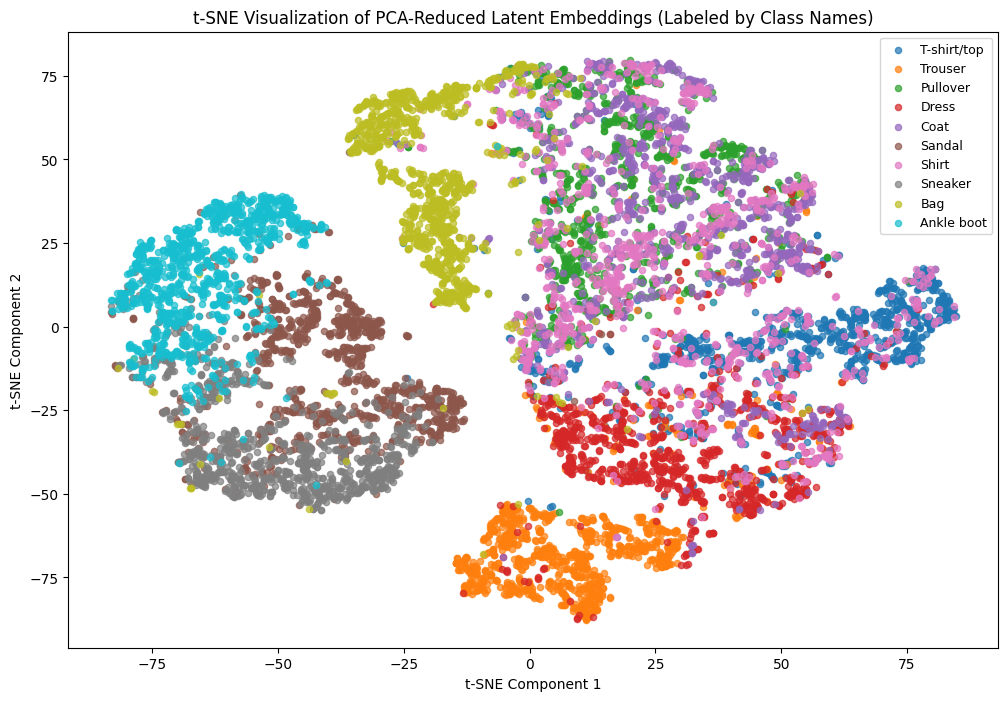

In [16]:
# Plot t-SNE results with class names
plt.figure(figsize=(12, 8))

# Plot each class separately
for i, class_name in enumerate(class_names):
    idx = np.where(y_test == i)
    plt.scatter(
        X_tsne_from_pca[idx, 0],
        X_tsne_from_pca[idx, 1],
        label=class_name,
        alpha=0.7,
        s=20
    )

plt.legend(loc="best", fontsize=9)
plt.title("t-SNE Visualization of PCA-Reduced Latent Embeddings (Labeled by Class Names)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# **use UMAP to the latent embeddings and visualize the results**

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00


In [17]:
#Import UMAP lib
import umap

# Apply UMAP to reduce from 64D to 2D
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(latent_embeddings)

# Check shape after UMAP
print(f"UMAP reduced shape: {X_umap.shape}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP reduced shape: (10000, 2)


UMAP Cluster Visualization

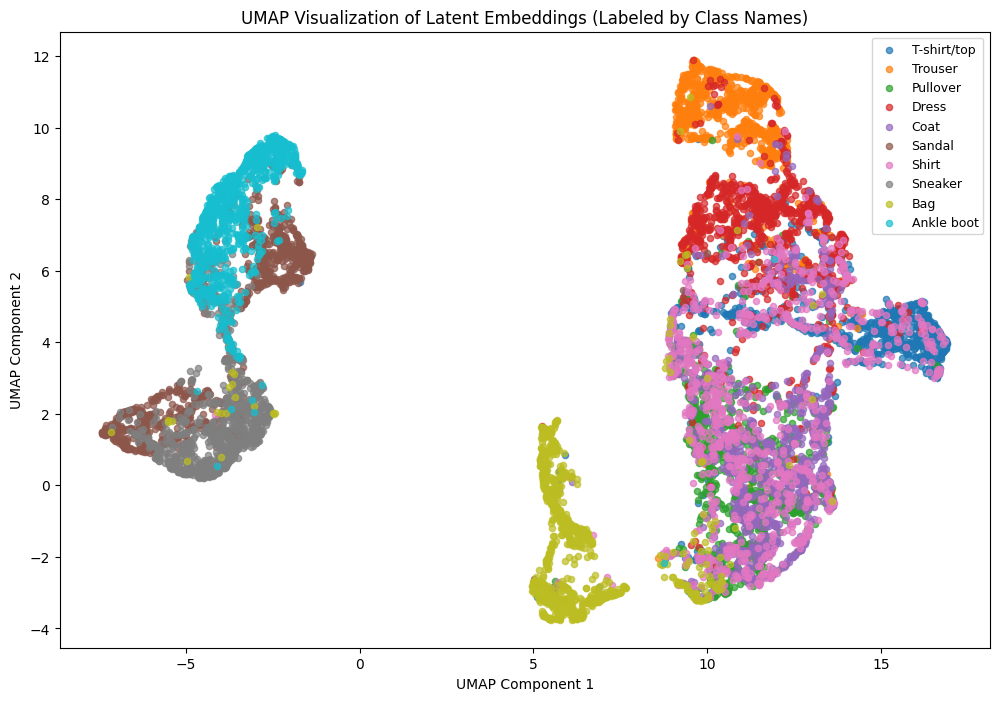

In [18]:
# Plot UMAP results with class names
plt.figure(figsize=(12, 8))

# Plot each class separately
for i, class_name in enumerate(class_names):
    idx = np.where(y_test == i)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        label=class_name,
        alpha=0.7,
        s=20
    )

plt.legend(loc="best", fontsize=9)
plt.title("UMAP Visualization of Latent Embeddings (Labeled by Class Names)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

Applying DBSCAN for UMAP

*   Adjust **eps** - lower eps Leads to more clusters and fewer merges.



In [19]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Apply DBSCAN to UMAP-reduced data
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can tune eps and min_samples
dbscan_labels = dbscan.fit_predict(X_umap)

# Count unique clusters (DBSCAN labels noise points as -1)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Calculate Silhouette Score (excluding noise points)
if n_clusters > 1:
    score = silhouette_score(X_umap[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"Silhouette Score for DBSCAN: {score:.2f}")
else:
    print("Not enough clusters to compute Silhouette Score.")

Estimated number of clusters: 3
Estimated number of noise points: 0
Silhouette Score for DBSCAN: 0.47


Visualize DBSCAN cluster from UMAP reduced data

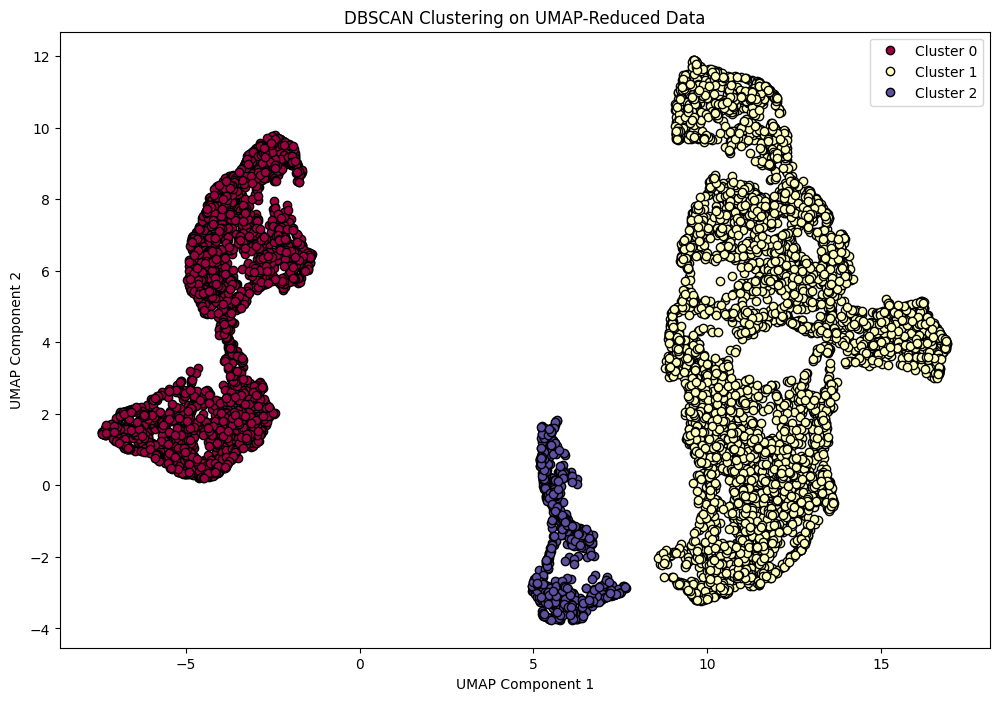

In [20]:
# Plot DBSCAN clusters on UMAP-reduced data
plt.figure(figsize=(12, 8))

# Assign colors: -1 (noise) will be plotted in black
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for label, col in zip(unique_labels, colors):
    if label == -1:
        # Black for noise points
        col = [0, 0, 0, 1]
        label_name = 'Noise'
    else:
        label_name = f'Cluster {label}'

    class_member_mask = (dbscan_labels == label)
    xy = X_umap[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, label=label_name)

plt.title("DBSCAN Clustering on UMAP-Reduced Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(loc="best")
plt.show()

Apply HDBSCAN for the UMAP Reduced data

In [ ]:
!pip install hdbscan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 73.0 MB/s eta 0:00:00


**Setting up HDBSCAN**

Key HDBSCAN Parameters:





*   min_cluster_size → Minimum number of points to form a cluster.
*   min_samples → Similar to DBSCAN, controls how "dense" a region must be to form a cluster.
*   cluster_selection_epsilon → Defines how much separation is required between clusters.



In [21]:
#import
import hdbscan
# Apply HDBSCAN
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=10, cluster_selection_epsilon=0.5)
hdbscan_labels = hdbscan_cluster.fit_predict(X_umap)

# Count unique clusters (HDBSCAN labels noise points as -1)
n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise = list(hdbscan_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Estimated number of clusters: 3
Estimated number of noise points: 0


**Visualize HDBSCAN from UMAP reduced data**

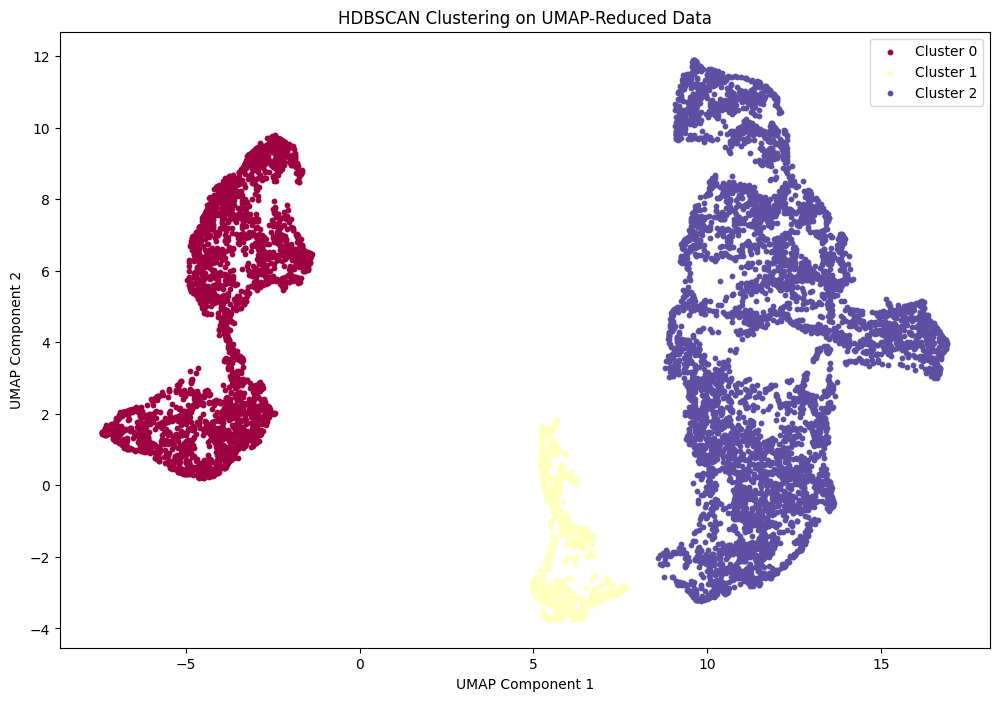

In [22]:
# Plot HDBSCAN clusters on UMAP-reduced data
plt.figure(figsize=(12, 8))

# Assign colors: -1 (noise) will be plotted in black
unique_labels = set(hdbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for label, col in zip(unique_labels, colors):
    if label == -1:
        # Black for noise points
        col = [0, 0, 0, 1]
        label_name = 'Noise'
    else:
        label_name = f'Cluster {label}'

    class_member_mask = (hdbscan_labels == label)
    xy = X_umap[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=label_name, s=10)

plt.title("HDBSCAN Clustering on UMAP-Reduced Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(loc="best")
plt.show()
